In [ ]:
import numpy as np

from glob import glob
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns


from PIL import Image
from skimage import io, color, img_as_float, img_as_ubyte
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import transforms
from torchvision.models import resnet50
from torchvision.datasets import ImageFolder

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

!pip install torchinfo
from torchinfo import summary

#
# install grad-cam library 
# https://github.com/jacobgil/pytorch-grad-cam
#
!pip install grad-cam
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

!nvidia-smi

PyTorch Version:  1.7.1
Torchvision Version:  0.8.2
Tue Feb  7 15:31:40 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.34       Driver Version: 430.34       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:19:00.0 Off |                  N/A |
| 24%   29C    P8     3W / 250W |   4702MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:1A:00.0 Off |                  N/A |
| 24%   33C    P8     6W / 250W |     11MiB / 11019MiB |      0%      Default |
+-------------------------------+---

In [ ]:
!python --version

root_path = "/media/kondo/Ext4_for_Colab/tomizawa/paper/" #@param {type:"string"}
#@markdown  - Assign a path for your root directory. This root directory should include an image dataset directory ("/data/data_original/") and "/utils/" directory.
#@markdown  - The image dataset is available at a database (URL in #README on the GitHub).
#@markdown  - The library "utils" is available at the same GitHub page with this jupyter notebook.

%cd $root_path 
!pwd
!ls

Python 3.6.10 :: Anaconda, Inc.
/media/kondo/Ext4_for_Colab/tomizawa/paper
/media/kondo/Ext4_for_Colab/tomizawa/paper
data	   figures  results_old		 results_test
data_old1  results  results_randomLabel  utils


In [ ]:
from utils.loaders import Args, ImageTransform, MarchantiaDataset, MaskDataset, get_data, indices_to_loader
from utils.misc import get_unnormalize, get_datetime, makedirs, set_requires_grad_toFalse, train_model_pytorch_tutorial, compute_loss
from utils.misc import visualize_batch
from utils.misc import display_loss_acc, predict_testloader, test_loadedModel

from utils.cams import GradCAM_withGrad, calculate_cam, input_to_img
from utils.cams import get_cam_visualizations, get_cam_visualizations_withGrad, plot_cam_results, plot_gradients_activations
from utils.camCondition import CamConditionContainer

In [ ]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(dev)

cuda


In [ ]:
from math import ceil 
def make_binary(imgs, thresh=0.5):
  assert ceil(np.max(imgs)) == 1, f'np.max(img) : {np.max(imgs)}'
  masks_array = imgs.copy()
  masks_array[masks_array >= thresh] =1
  masks_array[masks_array < thresh] =0
  return masks_array

def calculate_IoU(array1, array2, axis=(1,2)):
  """
  array1, array2 : 3 dimentional np.array/torch.Tensor. Their axis order should be (batch-size, H, W) in default setting (axis=(1,2)).  
  """
  assert array1.shape == array2.shape, f'Shape does not match between array1 and array2. {array1.shape} != {array2.shape}'
  Intersection = array1 * array2
  Union = array1 + array2
  Union[Union != 0]=1
  IoU = np.sum(Intersection, axis=axis)/np.sum(Union, axis=axis) #IoU = (Intersection)/(Union)
  return IoU

In [ ]:
# show img of 1 channel
def visualize_mask_batch(images, ncols=4):
    fig, ax = plt.subplots(nrows=1, ncols=ncols, figsize=(3*ncols, 3))
    for n in range(ncols):
        img = images[n]
        ax[n].imshow(np.squeeze(img), cmap='gray')
        ax[n].axis('off')

## calculate cam for teacher label
def cams_forLoader_trueLabel(cam_model, test_loader):
    outputs_cam = []
    for inputs, labels in test_loader:
        targets_tmp = [ClassifierOutputTarget(label) for label in labels]
        cam_tmp = cam(inputs, targets_tmp)
        outputs_cam.append(cam_tmp)
    outputs_cam = np.vstack(outputs_cam)
    return outputs_cam

def make_test_masks(args, Transform, mask_batch_size):
    full_mask_dataset = ImageFolder(root=args.mask_path)
    dataset_mask = MaskDataset(full_mask_dataset, Transform.data_transform["no_Normalize"]) ## 1 channel, without normalization
    test_mask_loader = indices_to_loader(args.model_path, 'indices_test.csv', dataset_mask, batch_size=mask_batch_size)
    test_masks, _ = next(iter(test_mask_loader))
    test_masks = test_masks.detach().cpu().numpy()
    test_masks = np.squeeze(test_masks)
    test_masks = make_binary(test_masks) ## binarize, to cutoff intermediate values by resizing
    return test_masks


def make_DataFrame(IoU, day, strain, labels, preds):
  assert IoU.shape[0] == labels.shape[0], 'Shape mismatch: IoU and labels'
  assert preds.shape[0] == labels.shape[0], 'Shape mismatch: preds and labels'
  day_list = [day for _ in range(IoU.shape[0])]
  strain_list = [strain for _ in range(IoU.shape[0])]
  df_tmp = pd.DataFrame({'day':day_list, 'strain':strain_list, 'IoU':IoU})

  # [teacher M, F] x [correct, incorrect]
  if strain == 'Tak':
    column_labels = ['F' if label == 1 else 'M' for label in labels_test]
    df_tmp['labels'] = column_labels
    df_tmp['preds'] = ['F' if pred == 1 else 'M' for pred in preds_test]
  else: #Aus, RIL5
    column_labels = ['F' if label == 0 else 'M' for label in labels_test]
    df_tmp['labels'] = column_labels
    df_tmp['preds'] = ['F' if pred == 0 else 'M' for pred in preds_test]

  column_correct = ['correct' if TF else 'incorrect' for TF in (labels_test == preds_test) ]
  df_tmp['correct'] = column_correct
  df_tmp['hue'] = [label + '-' + correct for label, correct in zip(column_labels, column_correct)]
  return df_tmp



In [ ]:
def cams_forLoader_predictedLabel(cam_model, test_loader, preds_test):
    outputs_cam = []
    start = 0
    for inputs, labels in test_loader:
        N_labels = len(labels)
        preds = preds_test[start :start + N_labels]
        targets_tmp = [ClassifierOutputTarget(pred) for pred in preds]
        cam_tmp = cam(inputs, targets_tmp)
        outputs_cam.append(cam_tmp)
        start += N_labels
    outputs_cam = np.vstack(outputs_cam)
    return outputs_cam



In [ ]:
def get_args(strain, day, ablation, multilabel=False):
  args = Args()
  args.root =  './data/data_' + ablation + '/' + strain + '/' + day
  args.mask_path =  './data/data_mask/' + strain + '/' + day

  #outputs
  args.figure_rootpath = './figures/forGitHub/GradCAM/'
  args.figure_path = args.figure_rootpath + 'summary/'
  makedirs(args.figure_path)

  ### model
  model_path = glob('./results_forGitHub/*' + strain + '_' + day + '*/') if(multilabel==False)&(ablation=='original_noScaleBar')  else None
  model_path.sort()
  model_path = model_path[0]
  args.model_path = model_path
  args.model_fname = glob(args.model_path + '*.pt')[0]
  return args

def test_loadedModel(model_path, model, val_loader, dev, multilabel=False):
    #学習時に保存したbest val acc, loss
    val_accs = pd.read_csv(model_path + 'val_accs.csv', header=None)
    val_acc = np.max(val_accs)
    val_losses = pd.read_csv(model_path + 'val_losses.csv', header=None)
    val_loss = val_losses.values[np.argmax(val_accs)]
    print('epoch with max validation acc. : ' + str(np.argmax(val_accs)))
    print('saved validation loss: ', val_loss)
    print('saved validation acc: ', val_acc)

    #モデルをloadして新たに計算したval acc, loss
    loss, acc = compute_loss(model, val_loader, dev, multilabel)
    print(f'loss : {loss}, acc : {acc}')

    ## acc, lossが一致しない時はエラーを出して処理を止める
    assert int((val_acc - acc)*100)==0, 'an accuracy mismatch'
    assert int((val_loss - loss)*100)==0, 'a loss mismatch'
    return val_losses


In [ ]:
ablation = 'original_noScaleBar'
multilabel = False

IoU_mode = 'img' #'thallus','background'
label_mode = 'predicted' #'true', 'predicted'

strain_list = ['Aus', 'Tak', 'RIL5']
day_list = ['0d', '1d', '2d', '3d', '4d', '7d'] 

df = pd.DataFrame()
for strain in strain_list:
  for day in day_list:
      args = get_args(strain, day, ablation, multilabel)
      # print(args.__dict__)
      ## load a model
      model = resnet50(pretrained=False)
      num_ftrs = model.fc.in_features
      model.fc = nn.Linear(num_ftrs, 2)
      model.load_state_dict(torch.load(args.model_fname, map_location=torch.device('cpu')))
      model.to(dev);

      ## load a dataset
      Transform = ImageTransform(fill=0)
      full_dataset = ImageFolder(root=args.root)
      print(full_dataset)
      print(full_dataset.class_to_idx)
      dataset_noaug = MarchantiaDataset(full_dataset, Transform.data_transform["valid"])
      val_loader = indices_to_loader(args.model_path, 'indices_val.csv', dataset_noaug, batch_size=args.batch_size)
      test_loader = indices_to_loader(args.model_path, 'indices_test.csv', dataset_noaug, batch_size=args.batch_size)
      test_images, _ = next(iter(test_loader))
      visualize_batch(test_images); plt.show()
      display_loss_acc(args.model_path); plt.show()
      test_loadedModel(args.model_path, model, val_loader, dev, multilabel=multilabel)
      inputs_test, labels_test, outputs_test, preds_test = predict_testloader(model, test_loader, dev)
      print(preds_test.shape)
      print('test_acc : ', preds_test[preds_test == labels_test].shape[0]/preds_test.shape[0])

      ## Grad-CAM
      model.train()
      target_layers = [model.layer4[-1]]
      cam = GradCAM(model=model, target_layers=target_layers, use_cuda=torch.cuda.is_available())
      print('compute gradients : ', cam.compute_input_gradient)

      ## heatmap for true label
      ## Grad-CAM normalizes each heatmap to min0-max1
            
      if label_mode == 'predicted':
          outputs_cam = cams_forLoader_predictedLabel(cam, test_loader, preds_test)
      elif label_mode == 'true':
          outputs_cam = cams_forLoader_trueLabel(cam, test_loader)
      binary_cam = make_binary(outputs_cam)

      if IoU_mode == 'img': ## heatmap area = IoU with an image
          IoU = np.sum(binary_cam, axis=(1,2))/(binary_cam.shape[1]*binary_cam.shape[2])
      elif IoU_mode == 'thallus': ## IoU with a thallus(gemmaling)
          testset_size = preds_test.shape[0]
          test_masks = make_test_masks(args, Transform, testset_size)
          visualize_mask_batch(test_masks); plt.show()
          print(test_masks.shape)
          IoU = calculate_IoU(test_masks, binary_cam)
      elif IoU_mode == 'background': ##　IoU with background
          testset_size = preds_test.shape[0]
          test_masks = make_test_masks(args, Transform, testset_size)
          test_masks = (test_masks - 1)*(-1)
          visualize_mask_batch(test_masks); plt.show()
          print(test_masks.shape)
          IoU = calculate_IoU(test_masks, binary_cam)

      ## DataFrame -> plot
      df_tmp = make_DataFrame(IoU, day, strain, labels_test, preds_test)
      display(df_tmp.iloc[:5])
      # sns.catplot(x="day", y="IoU", kind="swarm", data=df_tmp)
      # sns.catplot(x="day", y="IoU", hue='hue', hue_order=['F-correct', 'F-incorrect', 'M-correct', 'M-incorrect'], 
      #             kind="swarm", split=True, data=df_tmp)      
      df = pd.concat([df, df_tmp])

### plot and save
df.to_csv(args.figure_path + 'plot_summary_' + IoU_mode + '.csv')


Output hidden; open in https://colab.research.google.com to view.

plot :  img
label :  predicted


/home/kondo/anaconda3/envs/colabenv_py36/lib/python3.6/site-packages/seaborn/categorical.py:2971: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


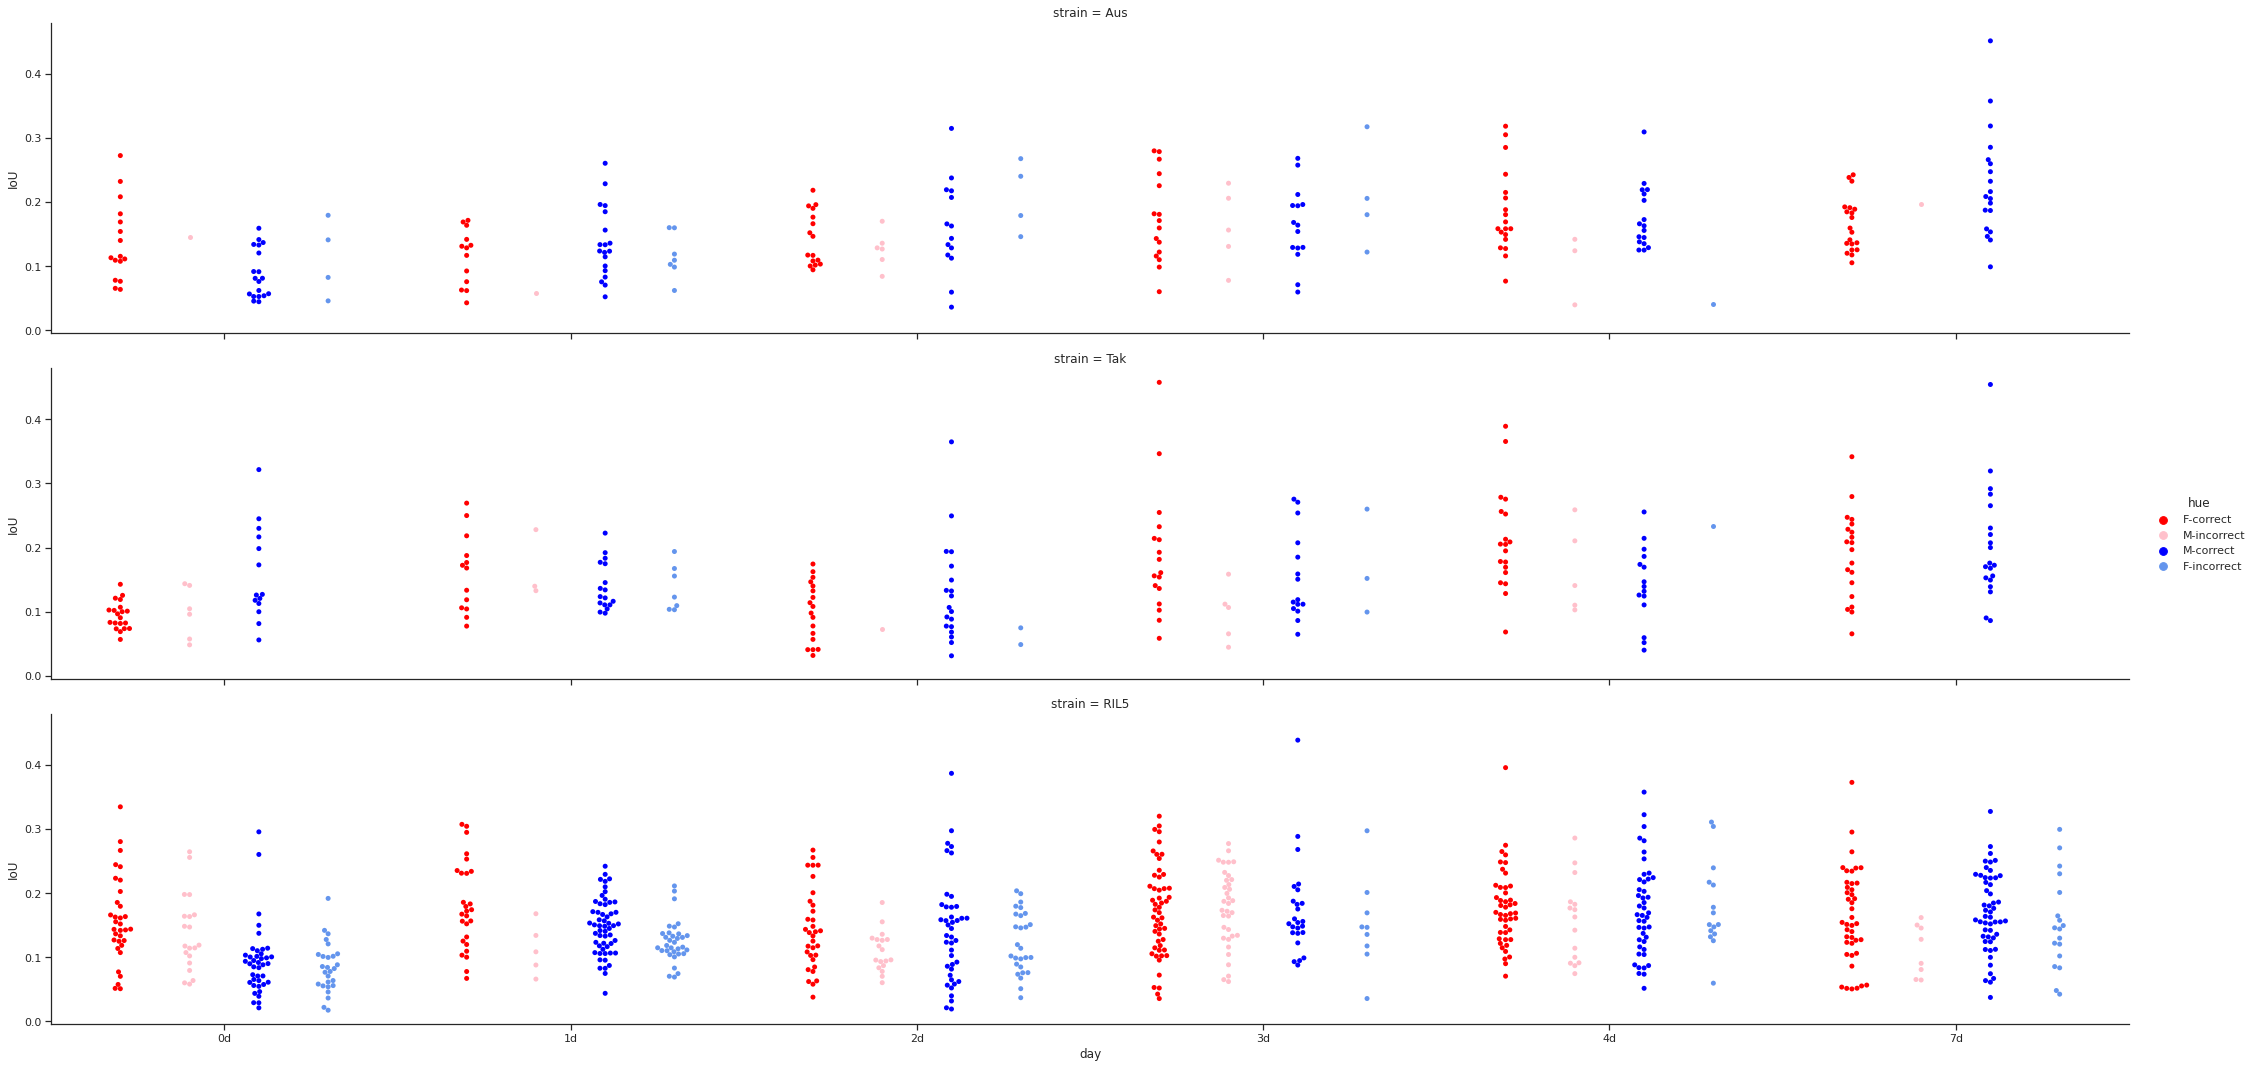

In [ ]:
print('plot : ', IoU_mode)
print('label : ' , label_mode)
sns.set(font_scale=1.0, style='ticks', rc={"lines.linewidth": 1, 'lines.markersize': 1})

if label_mode == 'predicted':
  g = sns.catplot(x="day", y="IoU", hue='hue',
            hue_order=['F-correct', 'M-incorrect', 'M-correct', 'F-incorrect'], 
            palette=['red', 'pink', 'blue', 'cornflowerblue'],
            kind="swarm", split=True, 
            row="strain", aspect=6,
            data=df)
elif label_mode == 'true':
  g = sns.catplot(x="day", y="IoU", hue='hue',
            hue_order=['F-correct', 'F-incorrect', 'M-correct', 'M-incorrect'], 
            palette=['red', 'orange', 'green', 'yellowgreen'],
            kind="swarm", split=True, 
            row="strain", aspect=6,
            data=df)

fig = g.fig

# print(args.figure_path + "IoU_" + IoU_mode + "_" + label_mode + "_labels.png")
# fig.savefig(args.figure_path + "IoU_" + IoU_mode + "_" + label_mode + "_labels.png", dpi=300)
# fig.savefig(args.figure_path + "IoU_" + IoU_mode + "_" + label_mode + "_labels.pdf", dpi=300) 